
# Building a movie recommendation system
##### Kevin Chou
April 8, 2017

## Introduction

More and more companies today are using big data to gain a competitive advantage over their competitors in the marketplace. The explosion of customer data in the last twenty years have prompted many companies to focus their company efforts on analytics in order to differentiate themselves. Banks, telecoms, and retailors are all leveraging their data to predict popular trends, prepare for future demand, and better understanding their customers’ wants and needs.

Personalized recommendations are an important part of any e-commerce site such as Amazon, Spotify, or Netflix, due to their ability to offer their customers a large number of choices in products, songs, and movies. Although having a large variety of options may seem great for the consumer, too many choices can often lead to ‘choice overload’, where the consumer becomes so overwhelmed with the number of options that they have difficulty making a decision. Personalized recommendations can solve this problem by preemptively suggesting to consumers the products that they think they will like. Successful recommendations lead to higher customer engagement, which means more sales and profit for the company.

### Hypothesis
In this project, I have built a recommendation system that can offer personalized movie recommendations for users based on movies that they have previously seen and rated, similar to what Netflix offers its customers.

A common rating system for movies is a 5-star rating scale; 1 star means “I hated it” and 5 stars means “I loved it”. The recommendation system is written in Python and will predict the star rating a user would likely to give to a movie, as well as give recommendations on movies that the user has not seen before.

In order to make successful movie recommendations for a particular user, the recommendation system will look for other users who have a similar rating pattern. The movie ratings from like-minded users are used to calculate the predicted ratings for movies that the base user has not seen. This technique is called user-based collaborative filtering.

The idea is that if user A has rated movies the same movies as user B similarly, then user A and B could be said to have the same tastes in movies. If user A gave 5 stars to a movie that user B hasn't rated yet, then user B might also rate that movie highly with 4 or 5 stars.

Example:

|        | Fences | Moonlight | Lion | Arrival | La La Land |
|--------|--------|-----------|------|---------|------------|
| Kevin  | 4      | 5         | 1    | 5       | 3          |
| Stacey | 5      | 4         | 2    |         | 3          |
| Joey   | 1      | 2         | 5    | 2       | 5          |

Suppose we have the movie ratings from for 5 different movies from 3 different users, as shown in the table above. Stacey has not seen Arrival but a prediction can be made on what Stacey will give it, based on the ratings that Kevin and Joey have given it.

Stacey rates her movies closer to Kevin than Joey, so we can predict that Stacey would likely give Arrival 4 or 5 stars since Kevin gave Arrival 5 stars.

## Data Preparation

The data needed to build this recommendation system was retrieved from the GroupLens Research website (https://grouplens.org/datasets/movielens/). GroupLens Research has collected movie ratings from the MovieLens website and has made them available for download as .CSV files.

The downloaded data has already been cleaned and prepared by GroupLens Research, no additional work was needed to prepare the data for analysis. There is around 20 million ratings across 27,000 movies by 138,000 users. All users have at least 20 movie ratings.

All of the data preparation and analysis is done within Python using the `pandas` and `numpy` packages and plots created using `matplotlib`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

np.seterr(divide='ignore', invalid='ignore') # Ignore some warning messages

all_ratings = pd.read_csv('ratings.csv')
all_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [2]:
print("There are %s unique user ids" % len(all_ratings['userId'].unique()))
print("There are %s unique movies" % len(all_ratings['movieId'].unique()))
print("There are %s ratings" % all_ratings.shape[0])

There are 138493 unique user ids
There are 26744 unique movies
There are 20000263 ratings


The `movies.csv` file was also read into a `pandas` DataFrame. This table will be used to extract the actual movie titles from a given `movieId`.

In [3]:
all_movies = pd.read_csv('movies.csv')
all_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
def movie_title_lookup(movieId):
    """Returns movie title from input movieId"""
    global all_movies
    return all_movies[all_movies['movieId'] == movieId].title.iloc[0]

#### Challenges
One of the largest challenge faced in this project was dealing with the size of the data. There are almost 140,000 unique users, so if the entirety of the data was used then a similarity score would need to be calculated for approximately 20 billion different user pairs. 

When I first attempted to run my analysis using the full dataset, my machine ran out memory and recieved `MemoryError` errors from Python. In order to combat this problem, I created a subset of the data by randomly selecting 5,000 users out of the 138,493 total users in the dataset.

In [5]:
# Create subset of ratings
np.random.seed(1)
user_subset = np.random.choice(all_ratings['userId'].unique(), 
                               size=5000, 
                               replace=False)
ratings = all_ratings[all_ratings['userId'].isin(user_subset)]

print("Subsetted data:")
print("%s unique user ids" % len(ratings['userId'].unique()))
print("%s unique movies" % len(ratings['movieId'].unique()))
print("%s ratings" % ratings.shape[0])

Subsetted data:
5000 unique user ids
14819 unique movies
762769 ratings


Another challenge was the run times of my code. A lot of time was spend optimizing the code, such as vectorizing the calculations and using `numpy` functions whenever possible. This sped the process up considerably.

#### Input Data

To prepare the data for analysis the imported ratings DataFrame was converted into a $N \times M$ matrix containing the movie ratings, where $N$ is the number of users and $M$ is the number of movies. Each row of this matrix represents a user and each column represents a movie and contains the movie rating from each user. If a user does not have a rating, the entry in the matrix is 0, making this a very sparse matrix.

In [6]:
# Some setup to prepare to create the ratings matrix
n_users = len(ratings['userId'].unique())
n_movies =len(ratings['movieId'].unique())

# Create some column/row to userid/movieid mappings
users_idx = {y:x for x, y in zip(range(n_users), 
                                 ratings['userId'].unique().tolist())}
movie_idx = {y:x for x, y in zip(range(n_movies), 
                                 ratings['movieId'].unique().tolist())}
movie_idx_reverse = {v:k for k,v in movie_idx.items()}

# Constants for getting data out of the ratings dataframe
USER_ID = 1
MOVIE_ID = 2
MOVIE_RATING = 3

In [7]:
# Create the NxM ratings matrix
ratings_m = np.zeros((n_users, n_movies))

for row in ratings.itertuples():
    ratings_m[users_idx[row[USER_ID]]-1, 
              movie_idx[row[MOVIE_ID]]-1] = row[MOVIE_RATING]

Example of the first five columns and rows of the ratings matrix:

In [8]:
ratings_df_ex = pd.DataFrame(ratings_m).ix[:5, :5]
ratings_df_ex.columns = [movie_title_lookup(x) 
                         for x in [movie_idx_reverse[c] 
                         for c in ratings_df_ex.columns]]

ratings_df_ex

,Toy Story (1995),GoldenEye (1995),Ace Ventura: When Nature Calls (1995),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Clueless (1995),Bio-Dome (1996)
0,0.0,0.0,0.0,0.0,0.0,4.0
1,3.0,3.0,0.0,3.0,0.0,3.0
2,3.0,4.0,5.0,2.0,0.0,3.0
3,0.0,2.0,3.5,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0


The ratings matrix will be used as the input data for predictive model.

### Predictive Model

#### Setting up training and test sets
The movie ratings matrix is first split into a training and test set before any analysis. The training set will be used to train the model and the test set will be used to validate the model. To construct the test set, five movies were removed from each user from the ratings matrix. The remaining ratings in the dataset afterwards will be used as the training set.

In [9]:
def create_train_and_test(ratings, n):
    """Splits input ratings dataset into train and test sets.
    n = number of movies to remove for test set for each user 
    """
    train = ratings.copy()
    test = np.zeros(ratings.shape)
    
    for user in range(ratings.shape[0]):
        # Choose n random movies to remove from each user 
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=n, 
                                        replace=False)
        
        # Prepare test set, and set ratings to 0 in training set
        train[user, test_ratings] = 0 
        test[user, test_ratings] = ratings[user, test_ratings]
    return train, test

In [10]:
train, test = create_train_and_test(ratings_m, 5)

#### The Model
The recommendation system uses the collaborative filtering technique to predict a user's movies ratings by looking at the ratings of other users with similar taste in movies. 

In order to measure how similar two users' taste in movies are, the Cosine Similarity metric will be calculated using both user's movie ratings.  Cosine Similarity is defined as:

$$
\text{Cosine Similarity}(u_i, u_j) = \frac{u_i \cdot u_j}{||u_i||*||u_j||}
$$

Where $u_i$, and $u_j$ are the movie ratings vectors for user $i$ and user $j$, respectively.

In [11]:
def calc_cosine_similarity(x):
    """input: movies ratings matrix
     outputs: nxn cosine similarity matrix
    """
    dot_prods = x.dot(x.T)

    norms = np.sqrt(np.diagonal(dot_prods))
    norms1 = norms.reshape((len(norms), 1))
    norms2 = norms.reshape((1, len(norms)))

    return dot_prods / norms1 / norms2

The cosine similarities are calculated for every user pair in the training set. Below is an example of the calculated cosine similiarity matrix, showing the similiarities between the first 6 users.

In [12]:
# Calculate cosine similiarity matrix using the training set
cosine_sim = calc_cosine_similarity(train)
pd.DataFrame(cosine_sim).ix[:5,:5]

,0,1,2,3,4,5
0,1.000000,0.198049,0.275326,0.059327,0.118528,0.103155
1,0.198049,1.000000,0.325563,0.047535,0.063375,0.000000
2,0.275326,0.325563,1.000000,0.166773,0.091690,0.110688
3,0.059327,0.047535,0.166773,1.000000,0.031020,0.059195
4,0.118528,0.063375,0.091690,0.031020,1.000000,0.000000
5,0.103155,0.000000,0.110688,0.059195,0.000000,1.000000


#### $k$ nearest neighbours
The model will implement a $k$-nearest neighours algorithm using the cosine similarity as the distance metric. The $k$ most similar users' movie ratings will be used calculate the predicted movie ratings. 

Below is a function written to find the userId's for the $k$ nearest users with the highest Cosine Similarity.

In [13]:
def get_k_nearest_users(user, k, sim):
    user_similarities = sim[user]    # Get similarities of OTHER users
    descending_idx = user_similarities.argsort()[::-1] # Ranked index 
    
    # If K > number of other users, use all users
    if k > sim.shape[0] - 1:
        k_nearest_users = descending_idx[1:]
    else:
        k_nearest_users = descending_idx[1:k+1]  

    return k_nearest_users

#### Predicted Ratings
The recommended ratings will be calculated by taking the the weighted average of the movie ratings given by the $k$ nearest neighbours.

$$
\text{predicted ratings} = {\frac{\sum_{i=1}^{k}\text{user ratings}_i * w_i}{\sum_{i=1}^{k}w_i}}
$$

Two different averages are tested: the arithmetic mean and an weighted average weighted by the users' Cosine Similarity.

In [47]:
def recommend_ratings_for_user(user, k, sim, dataset, weighted_avg=True): 
    
    # if K > number of users, use number of users.
    if k > sim.shape[0] - 1: k = sim.shape[0] - 1

    k_nearest_users = get_k_nearest_users(user, k, sim) # K most similiar users
    k_nearest_sim = sim[user][k_nearest_users] # similarities of K users    
    k_nearest_ratings = dataset[k_nearest_users] # ratings of K users       

    if weighted_avg:
        weights = (k_nearest_ratings != 0) * np.reshape(k_nearest_sim, (k, 1))
    else:
        weights = (k_nearest_ratings != 0)
        
    recommended_ratings = (k_nearest_ratings * weights).sum(axis=0) / weights.sum(axis=0)
    return np.nan_to_num(recommended_ratings)

def get_all_recommended_Ratings(k, sim, dataset, weighted_avg=True):
    all_recommended = np.zeros(dataset.shape)
    for user in range(dataset.shape[0]):
        all_recommended[user] = recommend_ratings_for_user(user, k, sim, dataset, weighted_avg)
    return all_recommended

The resulting recommended ratings matrix is also a $N \times M$ matrix, where each row represents a user's recommended ratings.

As an example, below are the recommended ratings calculated with $k=5$.

In [15]:
recommended_ratings_ex = get_all_recommended_Ratings(k=5, 
                                                     sim=cosine_sim, 
                                                     dataset=train)

In [16]:
rcmmd_ratings_df_ex = pd.DataFrame(recommended_ratings_ex).ix[:5, :5]
rcmmd_ratings_df_ex.columns = [movie_title_lookup(x) 
                               for x in [movie_idx_reverse[c] 
                               for c in rcmmd_ratings_df_ex.columns]]

rcmmd_ratings_df_ex.round(2)

,Toy Story (1995),GoldenEye (1995),Ace Ventura: When Nature Calls (1995),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Clueless (1995),Bio-Dome (1996)
0,3.0,0.00,3.51,0.00,0.0,4.26
1,3.4,2.20,4.25,3.00,0.0,4.80
2,3.0,2.61,3.80,3.33,1.0,4.60
3,3.0,1.97,4.40,0.00,0.0,3.71
4,0.0,5.00,0.00,0.00,0.0,3.50
5,4.5,2.50,4.50,0.00,0.0,5.00


#### Model Performance

The model still needs to be trained to find the optimal $k$ that would produce the best predictions. To validate the model, the Mean Absolute Error was calculated for all user ratings and predicted ratings. The Mean Absolute Error was chosen over the Mean Squared Error to use to measure the performance of the model because the MAE is easier to interpret for this particular project. For this recommendation system, the MAE can be interpreted as the average difference in stars between the users' actual ratings and their predicted ratings.

Mean Absolute Error is defined as:

$$
MAE = \frac{1}{N} \sum_{i=1}^{N}{\mid \text{actual rating}_i - \text{predicted_rating}_i \mid}
$$

Where $N$ is the total number of ratings available.

In [17]:
def calc_mae(actual, predicted):
    # Flatten the ratings matrix into 1D array
    actual_flat = actual.flatten()
    predicted_flat = predicted.flatten()
    
    # Only compare movies where ratings available for both 
    actual_nonzero = actual_flat.nonzero()
    predicted_nonzero = predicted_flat[actual_nonzero].nonzero()

    # Final actual and predicted values
    a = actual_flat[actual_nonzero][predicted_nonzero]
    p = predicted_flat[actual_nonzero][predicted_nonzero]
    
    return np.sum(abs(a - p))  / len(a)

#### Training the model

A function was created that to calculate the MSE using different values of $k$.

In [18]:
def test_model(k_list, sim, dataset, weighted_avg=True):
    all_errors = []
    all_rcmmndd_ratings = {}
    
    for k in k_list:
        recommended_ratings = get_all_recommended_Ratings(k, sim, dataset, 
                                                          weighted_avg)
        e = {'K':k, 'MAE': calc_mae(dataset, recommended_ratings)}
        
        all_errors.append(e)
        all_rcmmndd_ratings['k'] = recommended_ratings
    
    return pd.DataFrame(all_errors), all_rcmmndd_ratings

The model will be tested using various values for $k$, from $k=1$ to using all possible users ($k=5000$), using the non-weighted mean and a weighted mean using cosine similarity.

In [19]:
k_list = [1, 10, 50, 100, 250, 500, 1000, 2000, 3000, 4000, 5000]

In [20]:
# The code below took 12 hours to run!!
mse_test_nw = pd.read_csv("k_mse_test_nw.csv")
mse_train_nw = pd.read_csv("k_mse_train_nw.csv")
mse_test_w = pd.read_csv("k_mse_test_w.csv")
mse_train_w = pd.read_csv("k_mse_train_w.csv")

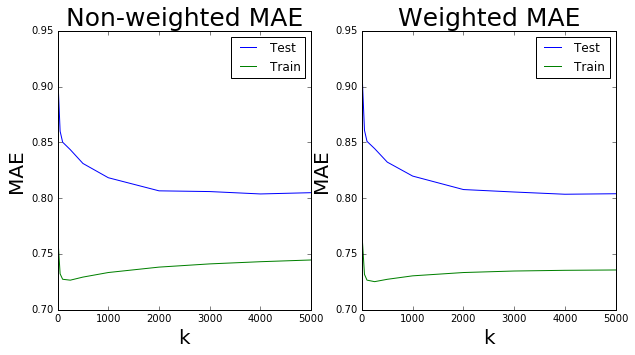

In [21]:
fig = plt.figure(figsize=(10,5))

# Plot non-weighted models
plt.subplot(121)
plt.plot(k_list, mse_test_nw['MAE'], label='Test')
plt.plot(k_list, mse_train_nw['MAE'], label='Train')
plt.legend(loc='best')
plt.xlabel('k', fontsize=20)
plt.ylabel('MAE', fontsize=20)
plt.title('Non-weighted MAE', fontsize=25)

# Plot weighted models
plt.subplot(122)
plt.plot(k_list, mse_test_w['MAE'], label='Test')
plt.plot(k_list, mse_train_w['MAE'], label='Train')
plt.legend(loc='best')
plt.xlabel('k', fontsize=20)
plt.ylabel('MAE', fontsize=20)
plt.title('Weighted MAE', fontsize=25)

plt.show()

MAE Values

In [22]:
mae_nw = mse_test_nw.merge(mse_train_nw, on='K', suffixes=('_test', '_train'))
mae_w = mse_test_w.merge(mse_train_w, on='K', suffixes=('_test', '_train'))
mae_all = mae_nw.merge(mae_w, on='K', suffixes=('_nw', '_w'))
mae_all.index = mae_all['K']
mae_all.index.name = 'K'

mae_all[['MAE_test_nw', 'MAE_test_w', 'MAE_train_nw', 'MAE_train_w']].round(4)

,MAE_test_nw,MAE_test_w,MAE_train_nw,MAE_train_w
K,,,,
1,0.9125,0.9125,0.8431,0.8431
10,0.9032,0.9039,0.7613,0.7613
50,0.8600,0.8609,0.7322,0.7317
100,0.8502,0.8509,0.7274,0.7266
250,0.8435,0.8444,0.7265,0.7252
500,0.8311,0.8323,0.7293,0.7273
1000,0.8183,0.8198,0.7334,0.7304
2000,0.8066,0.8078,0.7383,0.7334
3000,0.8059,0.8055,0.7411,0.7348


As expected, the Mean Absolute Error when tested against the training set is lower than the test set. However, we are training the recommendation to give the minimum MAE using the test set. Looking at the training set, $k=250$ gives the smallest MAE while the optimal $k$ for the test model appears to be at $k=4000$. 

The non-weighted model seems to perform slightly better than the weighed models for both training and test sets but only up until $k=3000$. The weighted-model starts to perform better when $k>3000$, but the differences are so small they are negligible.

The best performing model against the test set uses the Cosine Similarity weighted average calculated from the $k=4000$ most similar users. This model has the lowest Mean Absolute Error of 0.8035.

## Conclusion

In this project I've successfully created a working recommendation system that can accurately predict a user's movie ratings using collaborative filtering. By using only a subset of the data, I was able to create a recommendation system that was able to predict movie ratings that was off by less than 1 star rating on average. 

The best model takes the cosine similarity weighted average movie ratings from the $k=4000$ closest users, producing a model that has a Mean Absolute Error of 0.80.

#### Future Considerations
Only a subset (~4%) of the full dataset was used due to hardware and software restrictions. Using the full dataset could possibly improve the model's accuracy, but that would require a more powerful machine, more efficient code, or a different storage system. For example, the MovieLens data could've been imported into a relational database such as MySQL.

Further more, additional data could be incorporated into the model. The movies dataset contained a list of genres associated with each movie. This is additonal data that could be used to determine if user has a preference for certain genres, or could be used to group similar movies together. Data from other sources, such as user ratings from IMDB or RottenTomatos.com could be web scraped and incorporated into the model to improve the model.

#### Example
Below is an example of the recommend ratings and predicted movies outputted by the recommendation system for a user.

In [23]:
# Best model was the weighted avg with k=4000
recommended_ratings = ratings_test_w['4000']

In [24]:
def compare_ratings(user, dataset, recommended):
    user_ratings = dataset[user]
    recmd_ratings = recommended[user]    
    nonzeros = user_ratings.nonzero()
    ratings = pd.DataFrame({
            "actual":user_ratings[nonzeros],
            "predicted":recmd_ratings[nonzeros]})
    
    # Get the actual movieId's from index 
    ratings.index = ratings.index.map(lambda x: movie_idx_reverse[x])
    ratings = ratings.reset_index()
    ratings.columns = ['movieId', 'actual', 'predicted']
    
    # Calculate difference between the actual and predicted ratings
    ratings['abs_diff'] = abs(ratings['actual'] - ratings['predicted'])
    
    # Merge with movies dataframe to get movie title
    ratings_w_title = ratings.merge(all_movies, on='movieId')
    ratings_w_title = ratings_w_title[['title', 'actual', 'predicted', 'abs_diff']]
    
    return ratings_w_title[(ratings_w_title['actual'] != 0) & 
                           (ratings_w_title['predicted'] != 0)]

The top 5 closest predicted ratings for user 1988:

In [25]:
user = compare_ratings(1988, ratings_m, recommended_ratings)
user.sort_values('abs_diff').head()

,title,actual,predicted,abs_diff
16,"Net, The (1995)",3.5,3.576157,0.076157
12,Die Hard: With a Vengeance (1995),4.0,4.098329,0.098329
0,Toy Story (1995),3.0,3.157133,0.157133
9,Batman Forever (1995),4.0,3.809091,0.190909
2,Ace Ventura: When Nature Calls (1995),2.0,2.201682,0.201682


The worst 5 predicted ratings for the same user:

In [26]:
user.sort_values('abs_diff', ascending=False).head()

,title,actual,predicted,abs_diff
3,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),4.0,2.484240,1.515760
5,Bio-Dome (1996),4.5,3.000000,1.500000
18,Dumb & Dumber (Dumb and Dumber) (1994),3.5,2.334202,1.165798
8,Apollo 13 (1995),4.5,3.382469,1.117531
13,Hackers (1995),4.5,3.732516,0.767484


In [27]:
user['abs_diff'].mean()

0.5725463935387917

The average absolute difference for this user is 0.57. This means that the predicted ratings only differed from the user's actual ratings by an average of half a star.

Next, let's look at what movies the recommendation system would think this user would enjoy.

In [28]:
def recommend_movies_for_user(user, dataset, recommended, stars=4):
    """Return a DataFrame of movies that the input user has not rated. 
    Can specifiy the number of stars threshold)"""
    user_ratings = ratings_m[user]
    recmd_ratings = recommended_ratings[user]

    movies_user_havent_seen = (user_ratings == 0).nonzero()
    predicted_ratings = pd.DataFrame({'x': recmd_ratings[movies_user_havent_seen]})
    
    predicted_ratings.index = predicted_ratings.index.map(lambda x: movie_idx_reverse[x])
    predicted_ratings = predicted_ratings.reset_index()
    predicted_ratings.columns = ['movieId', 'predicted_rating']

    prdctd_w_title = predicted_ratings.merge(all_movies, on='movieId')
    prdctd_w_title = prdctd_w_title[['title', 'predicted_rating']]

    return prdctd_w_title[prdctd_w_title['predicted_rating'] >= stars]

In [29]:
recommended_movies = recommend_movies_for_user(user=1988, 
                                               dataset=ratings_m, 
                                               recommended=recommended_ratings)
recommended_movies.sort_values('predicted_rating', ascending=False).head(10)

,title,predicted_rating
2008,Out of Africa (1985),5.0
2327,Dumb and Dumber To (2014),5.0
3907,This Boy's Life (1993),5.0
4422,"Rugrats Movie, The (1998)",5.0
4129,Paths of Glory (1957),5.0
4809,Jade (1995),5.0
2987,Battleship Potemkin (1925),5.0
3061,For the Boys (1991),5.0
3104,Lean on Me (1989),5.0
835,No Country for Old Men (2007),5.0


## Sources

- Garrido, M. (2015, Dec 5). _A short introduction to Recommendation Systems_. Retrieved April 1, 2017, from Manuel Garrido's Blog: http://blog.manugarri.com/a-short-introduction-to-recommendation-systems/

- GroupLens Research. (2016, October). _MovieLens_. Retrieved April 1, 2017, from GroupLens: https://grouplens.org/datasets/movielens/

- Zacharski, R. (2015). _Recommendation Systems_. Retrieved April 1, 2017, from A Programmer's Guide to Data Mining: http://guidetodatamining.com/chapter2/

- Wikipedia, the free encyclopedia. (2017, March 19). _Collaborative filtering_. Retrieved April 1, 2017, from Wikipedia: https://en.wikipedia.org/wiki/Collaborative_filtering


